##Проект по предмету "Программирование роботов"

**Вартеванян Ольга Юрьевна**

**Зимирев Илья Александрович**

Группа:  R4136c


---

В самом начале устанавливаем и добавляем необходимые библиотеки

In [ ]:
!pip install gymnasium --quiet
!pip install pygame --quiet
!pip install numpy --quiet
!pip install matplotlib --quiet

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import math

Задаём среду симуляции

In [ ]:
env = gym.make("CartPole-v1", render_mode="human")
env.reset()

(array([ 0.03354321,  0.04690383, -0.04804916,  0.03200018], dtype=float32),
 {})

Задаем гиперпараметры

In [ ]:
num_episodes = 500                           #количество эпизодов
statistics_frequency = num_episodes // 20    #частота вывода статистики
target_reward = 500                          #желаемое количество наград в среднем за statisics_frequency шагов

Параметры дискретизации пространства состояний

In [ ]:
min_alpha = 0.1         #минимальное значение альфы
min_epsilon = 0.1       #минимальное значения эпсилона
discounting = 1.0       #значение дисконтирования

cart_pos_space = np.array([2.5])
cart_vel_space = np.array([10.0])
pole_ang_space = np.array([-0.336, -0.168, 0,  0.168, 0.326, 0.5])
pole_vel_space = np.array([-0.8, -0.65, -0.5, -0.32, -0.16, 0.0, 0.16, 0.32, 0.5, 0.65, 0.8, 10.0])
num_bins = [cart_pos_space.size, cart_vel_space.size, pole_ang_space.size, pole_vel_space.size]

#инициализация q-table
num_states = (num_bins[0], num_bins[1], num_bins[2], num_bins[3])
num_actions = env.action_space.n
q_values = np.zeros(num_states + (num_actions,))

#доп переменные для статистики
episode_rewards = []
q_statistics = np.zeros(num_states)

Функция дискретизации

In [ ]:
def discretize(observation):

    cart_pos_ind = np.digitize(observation[0], cart_pos_space)
    cart_vel_ind = np.digitize(observation[1], cart_vel_space)
    pole_ang_ind = np.digitize(observation[2], pole_ang_space)
    pole_vel_ind = np.digitize(observation[3], pole_vel_space)

    return (cart_pos_ind, cart_vel_ind, pole_ang_ind, pole_vel_ind)

Функция выбора действия

In [ ]:
#действие на основе эпсилон-жадного алгоритма
def act(state, epsilon):

    if np.random.uniform(0, 1) < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(q_values[state[0], state[1], state[2], state[3]])

Функция обновления Q

In [ ]:
def update(state, action, new_observation):

    new_state = discretize(new_observation)
    old_q_value = q_values[state][action]
    q_values[state][action] =  (1 - alpha) * old_q_value + alpha*(reward + discounting*np.max(q_values[new_state]))
    state = new_state

    return new_state, q_values

Функция вывода статистики

In [ ]:
def learning_statistics(num, reward):

    episode_rewards.append(reward)

    #вывод статистики полученных наград
    if num % (statistics_frequency) == 0:
        avg_reward = np.mean(episode_rewards[-statistics_frequency:])
        print(f'прогресс: {(num*100/num_episodes):.2f}% эпизодов, награда (ср. за {statistics_frequency} эп.): {avg_reward:.2f}')
        #информация о достижении желаемого количества наград
        if avg_reward >= target_reward:
            print(f'максимальное количество наград (ср. за {statistics_frequency}) достигнуто на {num} эпизоде')

Функция построения графика

In [ ]:
def graph(arr, x_lbl, y_lbl):

    arr = np.array(arr)
    fig = plt.figure()
    axs = fig.add_subplot()
    axs.plot(arr, color='magenta')
    axs.grid()
    font = {'style': 'italic','size': 10}
    axs.set_xlabel(x_lbl, fontdict=font)
    axs.set_ylabel(y_lbl, fontdict=font)
    plt.style.use('dark_background')


    plt.show()

Функция вывода статистики посещаемости состояний

In [ ]:
def state_statistics(q_statistics, num_bins):
    count0 = 0
    count1 = 0
    count2 = 0
    count3 = 0
    for i in range(num_bins[0]):
        for j in range(num_bins[1]):
            for k in range(num_bins[2]):
                for l in range(num_bins[3]):
                    if q_statistics[i][j][k][l] == 0: count0 += 1
                    if q_statistics[i][j][k][l] == 1: count1 += 1
                    if q_statistics[i][j][k][l] == 2: count2 += 1
                    if q_statistics[i][j][k][l]  > 2: count3 += 1

    percent_count0 = count0*100/(num_bins[0]*num_bins[1]*num_bins[2]*num_bins[3])
    percent_count1 = count1*100/(num_bins[0]*num_bins[1]*num_bins[2]*num_bins[3])
    percent_count2 = count2*100/(num_bins[0]*num_bins[1]*num_bins[2]*num_bins[3])
    percent_count3 = count3*100/(num_bins[0]*num_bins[1]*num_bins[2]*num_bins[3])

    print("\n")
    print(f"количество непосещенных состояний: {count0}, {percent_count0:.2f}%")
    print(f"количество посещенный 1 раз состояний: {count1}, {percent_count1:.2f}%")
    print(f"количество посещенный 2 раза состояний: {count2}, {percent_count2:.2f}%")
    print(f"количество посещенных больше двух раз состояний: {count3}, {percent_count3:.2f}%")
    print("\n")

Цикл обучения

In [ ]:
for episode in range(num_episodes):

    observation, info = env.reset()
    state = discretize(observation)
    episode_reward = 0
    done = False

    #уменьшение параметров с течением эпизодов
    epsilon = max(min_epsilon, min(1, 1.0 - math.log10((episode + 1) / 25)))
    alpha = max(min_alpha, min(1, 1.0 - math.log10((episode + 1) / 25)))


    #обновление окружения от действий агента
    while not done:
        q_statistics[state] += 1
        action = act(state, epsilon)
        new_observation, reward, terminated, truncated, info = env.step(action)

        #if abs(new_observation[0])>2.4: print("тележка")
        #if abs(new_observation[2])>0.2095: print("угол")

        state, q_values = update(state, action, new_observation)
        episode_reward += reward
        done = terminated or truncated

    #вывод статистики
    learning_statistics(episode, episode_reward)

прогресс: 0.00% эпизодов, награда (ср. за 25 эп.): 22.00
прогресс: 5.00% эпизодов, награда (ср. за 25 эп.): 21.32
прогресс: 10.00% эпизодов, награда (ср. за 25 эп.): 28.20
прогресс: 15.00% эпизодов, награда (ср. за 25 эп.): 29.16
прогресс: 20.00% эпизодов, награда (ср. за 25 эп.): 35.52
прогресс: 25.00% эпизодов, награда (ср. за 25 эп.): 111.08
прогресс: 30.00% эпизодов, награда (ср. за 25 эп.): 213.40
прогресс: 35.00% эпизодов, награда (ср. за 25 эп.): 436.92
прогресс: 40.00% эпизодов, награда (ср. за 25 эп.): 497.76
прогресс: 45.00% эпизодов, награда (ср. за 25 эп.): 488.72
прогресс: 50.00% эпизодов, награда (ср. за 25 эп.): 493.56
прогресс: 55.00% эпизодов, награда (ср. за 25 эп.): 500.00
максимальное количество наград (ср. за 25) достигнуто на 275 эпизоде
прогресс: 60.00% эпизодов, награда (ср. за 25 эп.): 495.40
прогресс: 65.00% эпизодов, награда (ср. за 25 эп.): 496.24
прогресс: 70.00% эпизодов, награда (ср. за 25 эп.): 496.28
прогресс: 75.00% эпизодов, награда (ср. за 25 эп.): 4

Результаты



количество непосещенных состояний: 30, 41.67%
количество посещенный 1 раз состояний: 2, 2.78%
количество посещенный 2 раза состояний: 1, 1.39%
количество посещенных больше двух раз состояний: 39, 54.17%




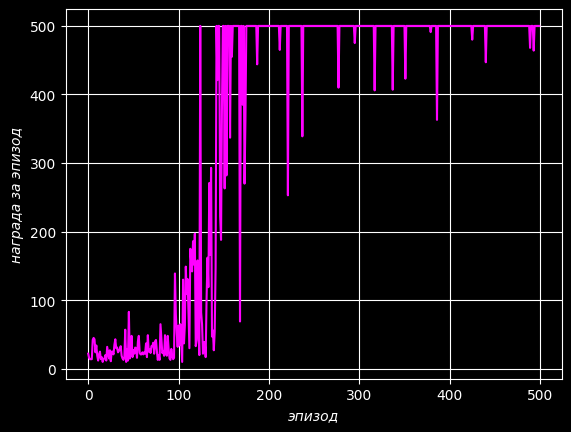

In [ ]:
#вывод статистики по состояниям
state_statistics(q_statistics, num_bins)

#вывод графика обучения
graph(episode_rewards, "эпизод", "награда за эпизод")

#закрытие окружения
env.close()